In [1]:
'''
This script makes a TOF plot based on the given data
'''

#most likely comment these out if you aren't running this in Jupyterlab
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
from scipy.stats import norm
import os #used for file operations
import pickle #used for saving temporary results

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams

In [3]:
def getAllFileNames(path, ext='.bin', overwrite = False, outputExtension = '.res'):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if ext in file:
                if ext == '.bin' and overwrite == False:
                    name, ext = os.path.splitext(os.path.join(r, file))
                    resultFile = name + outputExtension
                    if os.path.isfile(resultFile) == False:#if no result file add it to the list
                        files.append(os.path.join(r, file))
                else:
                    files.append(os.path.join(r, file))
                
    files.sort()
    return files

def loadResults(fileDir, outputExtension, runPixelList):
    resultFiles = getAllFileNames(fileDir, outputExtension)
    rawPixelValsEner = []
    rawPixelValsT0 = []
    for p in runPixelList:
        rawPixelValsEner.append([])
        rawPixelValsT0.append([])
    #now load these into memory
    for file in resultFiles:
        print('loading ', file, resultFiles.index(file), len(resultFiles), end = "\r")
        with open(file, "rb") as f:
            res = pickle.load(f) #load this files results
            #grab the results for the pixel
            enert0res = res[0]
            for pixel in runPixelList:
                pixelRes = enert0res[pixel] #grabs the results for this pixel from all the waveforms
                for wave in pixelRes: #iterate over the different waveforms
                    for result in wave:
                        rawPixelValsEner[pixelList.index(pixel)].append(result[1])
                        rawPixelValsT0[pixelList.index(pixel)].append(result[0])    
    return rawPixelValsEner, rawPixelValsT0

In [4]:
pixelList = [1]

windows = []
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/0-5ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/5-10ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/10-15ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/15-20ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/20-25ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/25-30ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/30-35ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/35-40ms/')
windows.append('/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/40-45ms/')

outputExtension = '.laDumbEner'

results = []
for win in windows:
    results.append(loadResults(win, outputExtension, pixelList))

In [6]:
#make the histogram and stuff now
def makeHistWithEnerCut(results, index, cut):
    m, b = 0.0008663969773644441, -0.00857053090547447
    cutT0s = []
    for i in range(len(results[0][index])):
        if results[0][index][i] * m + b > cut:
            cutT0s.append(results[1][index][i])
    return cutT0s

In [16]:
cuts = []
for res in results:
    cuts.append(makeHistWithEnerCut(res, 0, 3.5))

In [17]:
wholeT0s = np.empty(0)
for cut in cuts:
    scalefactor = cuts.index(cut)*500000
    cut = np.add(cut, scalefactor)
    wholeT0s = np.concatenate((wholeT0s, cut), axis=None)

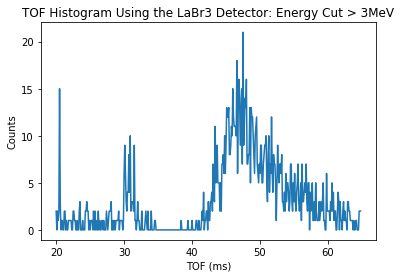

In [18]:
bins = np.arange(0,4500000, 10000)
hist, bins = np.histogram(wholeT0s, bins = bins)
plt.plot(bins[:-1] * 10/1000000 + 20, hist)
plt.xlabel('TOF (ms)')
plt.ylabel('Counts')
plt.title('TOF Histogram Using the LaBr3 Detector: Energy Cut > 3MeV')
plt.show()